# Benchmarks

In this notebook, we show timings of different parts of **seismiQB**: data generation, segmentation mask creation, model training. We perform each of them in multiple ways, showing different approaches and interfaces provided by our framework (and by **BatchFlow**).

Note that this is advanced notebook that requires you to read our other [tutorials and notebooks](./Carcass%20interpolation/01_M_cube.ipynb) to understand what is going on: we don't pay too much time explaining what exactly cells are doing and what is achieved by their code, we merely time it.

* [Data loading](data)
* [Model architecture](architecture)
* [Pipelines: loading, augmentation and training](pipelines)
* [Load + augmentation profile](profile1)
* [Model training profile](profile2)
* [Inference profile](inference)
* [Conclusion](conclusion)

In [1]:
# Necessary imports
import os
import sys
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 2000)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, IterableDataset
from pytorch_lightning import LightningModule, Trainer

sys.path.append('../seismiqb')
from seismiqb.batchflow import Pipeline, FilesIndex
from seismiqb.batchflow import B, V, C, F, D, P, R, W
from seismiqb.batchflow.batchflow.models.torch import EncoderDecoder, ResBlock # Note the import!

from seismiqb import SeismicCubeset, Horizon, plot_image

# Set GPU
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
# Global parameters
FREQUENCIES = [50]               # carcass frequency at `hard` and `easy` locations
CROP_SHAPE = (1, 256, 256)       # shape of sampled 3D crops
ITERS = 100                      # number of train iterations
BATCH_SIZE = 64                  # number of crops inside one batch

<a id='data'></a>
# Load everything

First of all, we load dataset with seismic cube and a horizon. This operation is performed once per dataset and does not take more that one minute even for all of our cubes (10 total) and horizons (50+ total).

In [3]:
%%time
cube_path = '/data/seismic/CUBE_2/M_cube.hdf5'
horizon_path = '/data/seismic/CUBE_2/RAW/t0_B_anon'

dsi = FilesIndex(path=[cube_path], no_ext=True)
dataset = SeismicCubeset(dsi)

dataset.load_geometries()
dataset.create_labels({dataset.indices[0]: [horizon_path]})

geometry = dataset.geometries[0]
horizon = dataset.labels[0][0]

CPU times: user 2.04 s, sys: 237 ms, total: 2.28 s
Wall time: 2.28 s


In [4]:
# Create carcass to train on
quality_grid = geometry.make_quality_grid(FREQUENCIES)
grid_coverage = (np.nansum(geometry.quality_grid) /
                 (np.prod(geometry.cube_shape[:2]) - np.nansum(geometry.zero_traces)))

# Create sampler, according to carcass
dataset.create_sampler(quality_grid=True)
dataset.modify_sampler('train_sampler', finish=True)

<a id='architecture'></a>
# Model architecture

In [5]:
class Dice(nn.Module):
    def forward(self, input, target):
        input = torch.sigmoid(input)
        dice_coeff = 2. * (input * target).sum() / (input.sum() + target.sum() + 1e-7)
        return 1 - dice_coeff

MODEL_CONFIG = {
    # Defining input shapes here allows to build model at initialization
    'inputs': {
        'images/shape': CROP_SHAPE,
        'masks/shape': CROP_SHAPE,
    },
    
    # Model layout
    'initial_block': {
        'inputs': 'images',
        'base_block': ResBlock,
        'filters': 16,
        'kernel_size': 5,
        'downsample': False,
    },

    'body/encoder': {
        'num_stages': 4,
        'order': 'sbd',
        'blocks': {
            'base': ResBlock,
            'n_reps': 1,
            'filters': [16, 32, 64, 128],
        },
    },
    'body/embedding': {
        'base': ResBlock,
        'n_reps': 1,
        'filters': 256,
    },
    'body/decoder': {
        'num_stages': 4,
        'upsample': {
            'layout': 'bna',
            'scale_factor': 2,
            'kernel_size': 2,
        },
        'blocks': {
            'base': ResBlock,
            'filters': [128, 64, 32, 16],
        },
    },
    'head': {
        'base_block': ResBlock,
        'filters': [16, 8],
    },
    'output': 'sigmoid',
    # Train configuration
    'loss': Dice(),
    'optimizer': {'name': 'Adam', 'lr': 0.01,},
    "decay": {'name': 'exp', 'gamma': 0.1},
    "n_iters": 150,
    'microbatch': 4,
    'common/activation': 'relu6',
}

The first call to a GPU takes some time in order to initialize CUDA states; to eliminate this time from actual model initialization time, we manually put some data to the GPU of choice:

In [6]:
np_tensor = np.random.random((10,)).astype(np.float32)

tensor = torch.from_numpy(np_tensor)
%time tensor = tensor.cuda()

tensor = torch.from_numpy(np_tensor)
%time tensor = tensor.cuda()

CPU times: user 2.73 s, sys: 8.18 s, total: 10.9 s
Wall time: 11.5 s
CPU times: user 37 µs, sys: 36 µs, total: 73 µs
Wall time: 80.6 µs


This time we create instance of model directly, without `init_model` action of `Pipeline`:

In [7]:
%%time
model = EncoderDecoder(MODEL_CONFIG)

CPU times: user 218 ms, sys: 158 ms, total: 376 ms
Wall time: 508 ms


<a id='pipelines'></a>
# All the pipelines

In [8]:
load_pipeline = (
    Pipeline()

    # Load data/masks
    .crop(points=D('train_sampler')(BATCH_SIZE),
          shape=CROP_SHAPE, make_slices='adaptive')
    .create_masks(dst='masks', width=5)
    .load_cubes(dst='images')
    .adaptive_reshape(src=['images', 'masks'], shape=CROP_SHAPE)
    .scale(mode='q', src='images')
) << dataset

In [9]:
aug_pipeline = (
    Pipeline()

    # Augmentations
    .transpose(src=['images', 'masks'], order=(1, 2, 0))
    .flip(axis=1, src=['images', 'masks'], seed=P(R('uniform', 0, 1)))
    .additive_noise(scale=0.005, src='images', dst='images')
    .rotate(angle=P(R('uniform', -15, 15)),
            src=['images', 'masks'])
    .scale_2d(scale=P(R('uniform', 0.85, 1.15)),
              src=['images', 'masks'])
    .elastic_transform(alpha=P(R('uniform', 35, 45)),
                       sigma=P(R('uniform', 4, 4.5)),
                       src=['images', 'masks'])
    .transpose(src=['images', 'masks'], order=(2, 0, 1))
) << dataset

In [10]:
model_pipeline = (
    Pipeline()

    # Initialize pipeline variables and model
    .init_variable('loss_history', [])
    .import_model(model, name='model')

    # Training
    .train_model('model',
                 fetches='loss',
                 images=B('images'),
                 masks=B('masks'),
                 save_to=V('loss_history', mode='a'))
) << dataset

<a id='profile1'></a>
# Data generation and augmentations profile

## Regular pipeline usage

That is how we usually use pipelines: simple `run` is enough

In [11]:
%%time
data_pipeline = load_pipeline + aug_pipeline
data_pipeline.run(D.size, n_iters=ITERS, bar=True)

100%|██████████| 100/100 [00:49<00:00,  2.01it/s]

CPU times: user 49.5 s, sys: 379 ms, total: 49.9 s
Wall time: 49.8 s


One of the design decisions of our framework is that items in our datasets are cubes: in that notebook, there is only one cube in the `dataset`, therefore, `D.size` evaluates to 1. The logic of converting *batch of cubes* into *batch of crops* is conveniently resides inside `crop` action: under the hood the conversion is performed by creating entirely new batch with generated crop locations. That somewhat confusing behaviour, where one needs to pass *number of cubes* as the `batch size` in `Pipeline.run` method while setting the actual amount of crops elsewhere, allows us to threat tasks with one or multiple cubes the same: there is virtually no changes to do in order to move from the task of carcass interpolation (one cube) to the inter-cube generalization (multiple cubes, as can be deduced by the name).

Setting `profile` argument of `run` to `True` allows us to monitor timings of every individual action; it takes some time to parse and log the profiling results, thus giving (a lot of) overhead. Note that the more iteration you run with `profile` on, the slower it becomes.

In [12]:
%%time
data_pipeline = load_pipeline + aug_pipeline
data_pipeline.run(D.size, n_iters=ITERS, bar=True, profile=True)

100%|██████████| 100/100 [01:39<00:00,  1.01it/s]

CPU times: user 1min 38s, sys: 336 ms, total: 1min 39s
Wall time: 1min 39s


Method `show_profile_info` returns a formatted dataframe that can be further explored:

In [13]:
result = data_pipeline.show_profile_info()
print('Total time of actions running: ', result['total_time']['sum'].sum())
result

Total time of actions running:  57.213385343551636


total_time                     pipeline_time            \
                             sum      mean       max           sum      mean   
action                                                                         
elastic_transform #10  15.411959  0.154120  0.166258     14.999765  0.149998   
rotate #8               7.580086  0.075801  0.081383      7.217586  0.072176   
additive_noise #7       7.481005  0.074810  0.080996      7.149832  0.071498   
scale_2d #9             6.999675  0.069997  0.076195      6.636490  0.066365   
flip #6                 6.363807  0.063638  0.072462      5.993128  0.059931   
load_cubes #2           3.722807  0.037228  0.047420      3.346373  0.033464   
crop #0                 2.004456  0.020045  0.030057      1.524752  0.015248   
create_masks #1         1.844219  0.018442  0.025536      1.522824  0.015228   
adaptive_reshape #3     1.674666  0.016747  0.020500      1.348560  0.013486   
transpose #5            1.484429  0.014844  0.018883      1.149107  0.011491   
transpose #11           1.468236  0.014682  0.016845      1.135425  0.011354   
scale #4                1.178039  0.011780  0.013573      0.867663  0.008677   

                                 
                            max  
action                           
elastic_transform #10  0.161600  
rotate #8              0.077463  
additive_noise #7      0.077438  
scale_2d #9            0.072260  
flip #6                0.068484  
load_cubes #2          0.043593  
crop #0                0.024778  
create_masks #1        0.021095  
adaptive_reshape #3    0.017133  
transpose #5           0.015492  
transpose #11          0.013454  
scale #4               0.010411

Each row in the dataframe corresponds to individual action: note that we have two `transpose` actions in our augmentation pipeline, thus multiple transposes appear in the table. `total_time` is time take by both action and pipeline inner workings; `pipeline_time` counts only the time of action running. Sub-columns `sum`, `mean` and `max` provide a more detailed description.

We can get a more detailed description of which exactly *lines of code* take the most time inside our actions by passing `detailed` argument to the `show_profile_info` method. To avoid cluttering in the notebook, we limit the output to two slowest calls per action:

In [14]:
data_pipeline.show_profile_info(detailed=True, limit=2)['tottime'][['sum']]

sum
action                id                                                          
adaptive_reshape #3   <built-in method numpy.core._multiarray_umath.i...  0.803258
                      _adaptive_reshape_::../seismiqb/seismiqb/batchf...  0.034883
additive_noise #7     <method 'standard_normal' of 'numpy.random.gene...  5.568668
                      _additive_noise_::../seismiqb/seismiqb/batchflo...  0.430587
create_masks #1       add_to_mask::../seismiqb/seismiqb/src/crop_batc...  0.630739
                      <built-in method numpy.zeros>::../seismiqb/seis...  0.227714
crop #0               _correct_point_to_grid::../seismiqb/seismiqb/sr...  0.206223
                      _correct_point_to_grid::../seismiqb/seismiqb/sr...  0.147251
elastic_transform #10 <remap>::../seismiqb/seismiqb/src/crop_batch.py...  5.607277
                      _elastic_transform_::../seismiqb/seismiqb/batch...  1.274312
flip #6               <flip>::../seismiqb/seismiqb/src/crop_batch.py:...  2.174169
                      _flip_::../seismiqb/seismiqb/batchflow/batchflo...  1.010007
load_cubes #2         <listcomp>::../seismiqb/seismiqb/src/geometry.p...  1.078837
                      <listcomp>::../seismiqb/seismiqb/src/geometry.p...  0.333350
rotate #8             <warpAffine>::../seismiqb/seismiqb/src/crop_bat...  5.713154
                      <built-in method numpy.core._multiarray_umath.i...  0.646805
scale #4              <built-in method numpy.core._multiarray_umath.i...  0.319770
                      scaler::../seismiqb/seismiqb/src/crop_batch.py:...  0.274888
scale_2d #9           <warpAffine>::../seismiqb/seismiqb/src/crop_bat...  5.139019
                      <built-in method numpy.core._multiarray_umath.i...  0.650193
transpose #11         <built-in method numpy.core._multiarray_umath.i...  0.655098
                      _apply_transform::../seismiqb/seismiqb/batchflo...  0.029948
transpose #5          <built-in method numpy.core._multiarray_umath.i...  0.664838
                      _apply_transform::../seismiqb/seismiqb/batchflo...  0.029965

We can also show individual timings for each iteration. That can be helpful to detect memory leaks and other cumulative errors:

In [15]:
data_pipeline.show_profile_info(per_iter=True).ix[:2]

total_time  pipeline_time         batch_id
iter action                                                           
1    elastic_transform #10    0.152584       0.148504  139764819866736
     rotate #8                0.075158       0.071542  139764819866736
     additive_noise #7        0.074349       0.071203  139764819866736
     scale_2d #9              0.069509       0.065906  139764819866736
     flip #6                  0.063535       0.059899  139764819866736
     load_cubes #2            0.038008       0.034222  139764819866736
     crop #0                  0.025153       0.019723  139764819866736
     create_masks #1          0.019000       0.015931  139764819866736
     adaptive_reshape #3      0.016274       0.013116  139764819866736
     transpose #11            0.014330       0.011235  139764819866736
     transpose #5             0.014269       0.011140  139764819866736
     scale #4                 0.012072       0.009128  139764819866736
2    elastic_transform #10    0.153873       0.149688  139764820177080
     rotate #8                0.074588       0.070991  139764820177080
     additive_noise #7        0.074496       0.071374  139764820177080
     scale_2d #9              0.071027       0.067477  139764820177080
     flip #6                  0.062900       0.059265  139764820177080
     load_cubes #2            0.037209       0.033576  139764820177080
     crop #0                  0.018707       0.013175  139764820177080
     create_masks #1          0.018103       0.015166  139764820177080
     adaptive_reshape #3      0.016557       0.013372  139764820177080
     transpose #11            0.014412       0.011315  139764820177080
     transpose #5             0.014351       0.011226  139764820177080
     scale #4                 0.011729       0.008854  139764820177080

Refer to [profiling tutorial](https://github.com/analysiscenter/batchflow/blob/master/examples/tutorials/08_profiling.ipynb) to learn more about exact collected information and how to format it.

## Pipeline as data generator

`Pipeline` has multiple interfaces; `gen_batch` allows to iterate over batches, using their attributes with data as usual `NumPy` arrays:

In [16]:
%%time
data_pipeline = load_pipeline + aug_pipeline 

for batch in tqdm(data_pipeline.gen_batch(D.size, n_iters=ITERS), total=ITERS):
    images, masks = batch.images, batch.masks

100%|██████████| 100/100 [00:49<00:00,  2.02it/s]

CPU times: user 49.5 s, sys: 160 ms, total: 49.6 s
Wall time: 49.6 s


You can pass the `profile` argument to the `gen_batch` method. For now, let's just make sure that `images` and `masks` variables contain what we expect:

images: (<class 'numpy.ndarray'>, dtype('float32'), (64, 1, 256, 256))
masks:  (<class 'numpy.ndarray'>, dtype('float32'), (64, 1, 256, 256))


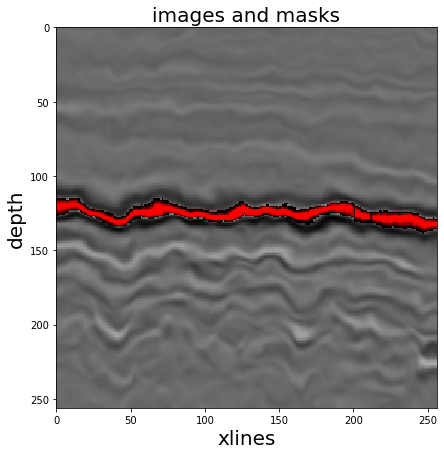

In [17]:
print(f'images: {(type(images), images.dtype, images.shape)}')
print(f'masks:  {(type(masks), masks.dtype, masks.shape)}')

plot_image((images[0, 0, ...], masks[0, 0, ...]), mode='overlap', y=1.,
           xlabel='xlines', ylabel='depth', title='images and masks')

## Convert pipeline to DataLoader

Sometimes, `PyTorch DataLoader` is convenient to use. Pipeline is already of a generative nature, so all we need to do is to wrap it into iterable dataset:

In [18]:
class PipelineDataset(IterableDataset):
    def __init__(self, pipeline, microbatch=4):
        self.pipeline = pipeline
        self.microbatch = microbatch
    
    def get_data(self):
        while True:
            batch = self.pipeline.next_batch(D('size'))
            images, masks = batch.images, batch.masks
                
            for i in range(0, len(images), self.microbatch):
                yield images[i:i+self.microbatch, ...], masks[i:i+self.microbatch, ...]

    
    def __iter__(self):
        return self.get_data()

In [19]:
%%time
pds = PipelineDataset(load_pipeline + aug_pipeline, microbatch=64)

# Note the `None` batch_size: it is already set as part of the loading pipeline
loader =  DataLoader(pds, batch_size=None, pin_memory=True)

for batch, _ in tqdm(zip(loader, range(ITERS)), total=ITERS):
    images, masks = batch

100%|██████████| 100/100 [00:50<00:00,  1.97it/s]

CPU times: user 1min 21s, sys: 153 ms, total: 1min 21s
Wall time: 50.7 s


In [20]:
print(f'images: {(type(images), images.dtype, images.shape)}')
print(f'masks:  {(type(masks), masks.dtype, masks.shape)}')

images: (<class 'torch.Tensor'>, torch.float32, torch.Size([64, 1, 256, 256]))
masks:  (<class 'torch.Tensor'>, torch.float32, torch.Size([64, 1, 256, 256]))


`DataLoader` converts all the data from regular `NumPy` arrays to `Torch.Tensor`s; nevertheless, underlying data is [shared](https://pytorch.org/docs/stable/tensors.html).

<a id='profile2'></a>
# Model train profile

Most of the cells do exactly the same, yet implore model training step as well.

## Regular pipeline usage

We run one iteration of something-GPU-related to ensure warm start for all of the subsequent cells:

In [21]:
%%time
train_pipeline = load_pipeline + aug_pipeline + model_pipeline
train_pipeline.run(D.size, n_iters=1, bar=True)

100%|██████████| 1/1 [00:02<00:00,  2.17s/it]

CPU times: user 1.15 s, sys: 611 ms, total: 1.76 s
Wall time: 2.17 s


In [22]:
%%time
train_pipeline.run(D.size, n_iters=ITERS, bar=True)

100%|██████████| 100/100 [01:56<00:00,  1.16s/it]

CPU times: user 1min 45s, sys: 10.8 s, total: 1min 56s
Wall time: 1min 56s


As before, we can use `profile` flag to get more detailed information:

In [23]:
%%time
train_pipeline = load_pipeline + aug_pipeline + model_pipeline
train_pipeline.run(D.size, n_iters=ITERS, bar=True, profile=True)

100%|██████████| 100/100 [03:01<00:00,  1.81s/it]

CPU times: user 2min 51s, sys: 10.3 s, total: 3min 1s
Wall time: 3min 1s


In [24]:
result = train_pipeline.show_profile_info()
print('Total time of actions running: ', result['total_time']['sum'].sum())
result['pipeline_time']

Total time of actions running:  125.57742524147034


,sum,mean,max
action,,,
train_model #13,67.294270,0.672943,0.738106
elastic_transform #10,15.023941,0.150239,0.160930
rotate #8,7.233566,0.072336,0.082903
additive_noise #7,7.183109,0.071831,0.083100
scale_2d #9,6.660368,0.066604,0.077033
flip #6,6.062070,0.060621,0.092544
load_cubes #2,3.402720,0.034027,0.050256
crop #0,1.539194,0.015392,0.025457
create_masks #1,1.559301,0.015593,0.022964


Note that this does not allow to profile individual GPU operations. You can this option in model configuration, in `train` method call or directly into the config of already existing model:

In [25]:
%%time
model.full_config['profile'] = True
train_pipeline.run(D.size, n_iters=ITERS, bar=True)
model.full_config['profile'] = False

100%|██████████| 100/100 [03:08<00:00,  1.89s/it]

CPU times: user 2min 53s, sys: 15.5 s, total: 3min 8s
Wall time: 3min 8s


As you can see, it takes a lot of time, though allows us to granularly inspect every cuda kernel time taken:

In [26]:
model.show_profile_info()

ncalls           CUDA_cumtime                      \
                              sum mean  max          sum      mean       max   
name                                                                           
CudnnConvolutionBackward    52800  528  528    25.878285  0.258783  0.281609   
cudnn_convolution_backward  52800  528  528    25.665558  0.256656  0.279475   
batch_norm                  57600  576  576    11.634008  0.116340  0.139933   
_batch_norm_impl_index      57600  576  576    11.365336  0.113653  0.136671   
CudnnBatchNormBackward      57600  576  576    10.272211  0.102722  0.108268   
cudnn_batch_norm_backward   57600  576  576     9.809088  0.098091  0.103369   
cudnn_batch_norm            57600  576  576     9.638830  0.096388  0.107895   
conv2d                      52800  528  528     7.942411  0.079424  0.098789   
convolution                 52800  528  528     7.687753  0.076878  0.096135   
_convolution                52800  528  528     7.438672  0.074387  0.086024   

                           CUDA_cumtime_avg                      
                                        sum      mean       max  
name                                                             
CudnnConvolutionBackward           0.049012  0.000490  0.000533  
cudnn_convolution_backward         0.048609  0.000486  0.000529  
batch_norm                         0.020198  0.000202  0.000243  
_batch_norm_impl_index             0.019731  0.000197  0.000237  
CudnnBatchNormBackward             0.017834  0.000178  0.000188  
cudnn_batch_norm_backward          0.017030  0.000170  0.000179  
cudnn_batch_norm                   0.016734  0.000167  0.000187  
conv2d                             0.015042  0.000150  0.000187  
convolution                        0.014560  0.000146  0.000182  
_convolution                       0.014088  0.000141  0.000163

## Pipeline as data generator

That is roughly the same as what goes under the hood of `model_train` action of `Pipeline`:

In [27]:
%%time
data_pipeline = load_pipeline + aug_pipeline

for batch in tqdm(data_pipeline.gen_batch(D.size, n_iters=ITERS), total=ITERS):
    images, masks = batch.images, batch.masks
    model.train(fetches='loss', images=images, masks=masks)

100%|██████████| 100/100 [01:55<00:00,  1.16s/it]

CPU times: user 1min 44s, sys: 10.8 s, total: 1min 55s
Wall time: 1min 55s


## Convert pipeline to DataLoader; use Lightning to train the model

Obviously, behind our `PyTorch` wrapper lies a plain old `PyTorch` model, that can be accessed via `model` attribute. There are also other attributes to store loss function, optimizer, etc. The `Lightning` wrapper just simply borrows them from our model:

In [28]:
class LightningModel(LightningModule):
    def __init__(self, bf_model, pipeline=None):
        super().__init__()
        self.bf_model = bf_model
        self.pipeline = pipeline
        
        self.loss_list = []
        
    def forward(self, x):
        return self.bf_model.model(x)
    
    def configure_optimizers(self):
        return self.bf_model.train_steps['']['optimizer']
    
    def training_step(self, batch, batch_idx):
        images, targets = batch
        predictions = self(images)
        
        loss_func = self.bf_model.train_steps['']['loss'][0]
        loss = loss_func(predictions, targets)
        
        self.loss_list.append(loss.detach().cpu().numpy())
        logs = {'loss': loss}
        return {'loss': loss, 'log': logs}
    
    def train_dataloader(self):
        if self.pipeline is not None:
            pds = PipelineDataset(self.pipeline,
                                  microbatch=self.bf_model.config.get('microbatch'))
            return DataLoader(pds, batch_size=None, pin_memory=True)

In [29]:
%%time
l_model = LightningModel(bf_model=model, pipeline=(load_pipeline + aug_pipeline) << dataset)

trainer = Trainer(gpus=1,
                  accumulate_grad_batches=16,    # reverse microbatch
                  max_steps=ITERS,               # number of iterations
                  weights_summary=None)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]


CPU times: user 5.61 ms, sys: 126 µs, total: 5.73 ms
Wall time: 4.92 ms


In [30]:
%%time
# Total iterations number is 800 = 16 * 100 = accumulated batches * ITERS 
trainer.fit(model=l_model)


CPU times: user 8min 12s, sys: 12.3 s, total: 8min 25s
Wall time: 2min 7s


1

<a id='inference'></a>
# Inference profile

During training we were sampling points along some sparce carcass: that procedure heavily benefits of caching mechanisms in our framework: we need to load very few slices of data during the whole process, so they are instantly loaded into cache and the cube is never touched again.

During inference the whole dynamic changes: we are moving from slice to slice sequentially, so each slide is used multiple times (and cache still works wonders), but the overall amount of cube access increases dramatically. Making more overlapping predictions (contolled by the `stride` argument of `make_grid`) benefits more from caching.

Action `assemble_crops` is not like the others: it is performed only once, at the end of pipeline run. Specifically:

- pipeline iterates over crops, cut from the cube in order to cover the required volume
- for each crop, it makes a prediction with trained neural network
- after all predictions are available, `assemble_crop` creates a huge 3D array from them, taking overlapping crops into account

In [31]:
inference_pipeline = (
    Pipeline()
    # Initialize everything
    .init_variable('result_preds', [])
    .import_model(model, name='model')

    # Load data
    .crop(points=D('grid_gen')(),
          shape=CROP_SHAPE)
    .load_cubes(dst='images')
    .adaptive_reshape(src='images', shape=CROP_SHAPE)
    .scale(mode='q', src='images')

    # Predict with model, then aggregate
    .predict_model('model',
                   B('images'),
                   fetches='predictions',
                   save_to=V('result_preds', mode='e'))
    .assemble_crops(src=V('result_preds'),
                    dst='assembled_pred',
                    grid_info=D('grid_info'),
                    order=(0, 1, 2))
) << dataset

In [32]:
dataset.make_grid(dataset.indices[0], CROP_SHAPE,
                  [0, 417], [0, 868], [800, 1000],
                  strides=(1, 96, 96),
                  batch_size=BATCH_SIZE*2)


for _ in tqdm(range(dataset.grid_iters)):
    batch = inference_pipeline.next_batch(D('size'), profile=True)

100%|██████████| 79/79 [00:56<00:00,  1.40it/s]


In [33]:
result = inference_pipeline.show_profile_info()
print('Total time of actions running: ', result['total_time']['sum'].sum())
result['pipeline_time']

Total time of actions running:  47.16252875328064


,sum,mean,max
action,,,
predict_model #5,28.682283,0.363067,0.506947
load_cubes #2,7.432154,0.094078,0.114220
assemble_crops #6,5.972275,0.075598,5.956178
scale #4,1.585292,0.020067,0.024276
adaptive_reshape #3,1.119633,0.014173,0.019175
crop #1,0.436509,0.005525,0.009697
import_model #0,0.002438,0.000031,0.000050


There is no use for the created 3D array: we need an actual 2D surface. That is done via `from_mask` staticmethod of `Horizon` class:

In [34]:
%%prun -l 10
horizons = Horizon.from_mask(batch.assembled_pred, dataset.grid_info,
                             minsize=50, threshold=0.5)

         532018 function calls (496594 primitive calls) in 1.732 seconds

   Ordered by: internal time
   List reduced from 1836 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.730    0.730    0.730    0.730 {skimage.measure._ccomp.label_cython}
      484    0.192    0.000    0.192    0.000 ffi.py:112(__call__)
        1    0.190    0.190    0.190    0.190 {built-in method scipy.ndimage._nd_image.find_objects}
        1    0.081    0.081    1.730    1.730 horizon.py:663(from_mask)
        1    0.069    0.069    0.069    0.069 {method 'nonzero' of 'numpy.ndarray' objects}
        3    0.065    0.022    0.065    0.022 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.037    0.037    0.037    0.037 utils.py:395(groupby_mean)
        1    0.016    0.016    0.016    0.016 horizon.py:707(<listcomp>)
    99762    0.014    0.000    0.025    0.000 {built-in method builtins.isinstance}
  290/288    0.013    0.000    0.

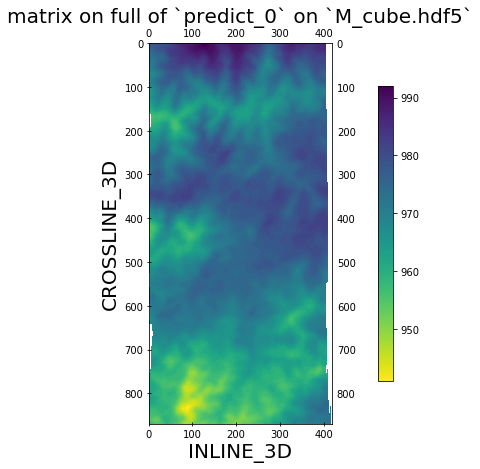

In [35]:
horizons[-1].show()

<a id='conclusion'></a>
# Conclusion

We presented detailed benchmarks for various parts of **seismiQB**, as well as showcased multiple interfaces to do data loading and model training. The timings of each approach are roughly the same, so the real difference is API.

This notebook is assumed to be run from time to time to monitor progress and speed-ups with following table to log them:

| date, DD.MM.YYYY | load + augmentations, s | load + augmentations + train, s | inference, s |
| --- | --- | --- | --- |
| 01.06.2019 | ~1600 | ~3600 | ~10000 |
| 01.06.2020 | 50 | 115 | 55 |